<a href="https://colab.research.google.com/github/warpaint77/SUPER20_Respiratory_Sound_Database/blob/main/TD_CNN_LSTM_SUPER_FinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Declarations

In [ ]:
#Aqui estão as declarações necessárias para o funcionamento correto do código.

from numpy.random import seed
seed(123)
import tensorflow as tf
tf.random.set_seed(123) 
import random as python_random
python_random.seed(1234)
from os import listdir
from tensorflow import keras
from tensorflow.keras import layers
import librosa as lb
import matplotlib.pyplot as plt
import numpy as np
import os 
import tensorflow.keras.layers.experimental.preprocessing as tfpreprocessing
import pandas as pd

In [ ]:
#Essa declaração aqui serve para acessar o seu google drive de modo que possamos importar os dados utilizados para treinar a rede de lá.
#OBS: Precisa da sua confirmação sempre que executado.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Aqui estão os caminhos para os diretórios que contém os dados utilizados para treinar o modelo mais a frente.
#OBS: Colocar aqui o caminho onde estão salvo os dados.

SPECTOGRAMS_ROOT_PATH = '/content/drive/MyDrive/lstm_data/new_data/'
PESOS_PATH = '/content/drive/MyDrive/lstm_data/pesos1.h5'

In [ ]:
#Aqui estão as classes que fazem parte do modelo treinado.

# classes = ['COPD', 'Healthy', 'Pneumonia', 'URTI']
classes = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

In [ ]:
#Aqui está o tamanho do batch (também conhecido como tamanho do lote mas eu prefiro quantidade de amostras por lote.)

BATCH_SIZE = 32

#Data Loading

In [ ]:
# Aqui estamos realizando o carregamento dos dados (espectrogramas) e dos rótulos que utilizaremos mais a frente para treinamento e teste.
x_train = np.load(os.path.join(SPECTOGRAMS_ROOT_PATH, 'x_train.npy'), allow_pickle=True)
y_train = np.load(os.path.join(SPECTOGRAMS_ROOT_PATH, 'y_train.npy'), allow_pickle=True)
x_test = np.load(os.path.join(SPECTOGRAMS_ROOT_PATH, 'x_test.npy'), allow_pickle=True)
y_test = np.load(os.path.join(SPECTOGRAMS_ROOT_PATH, 'y_test.npy'), allow_pickle=True)

In [ ]:
def transpose_data(data):
  """
    Função que retorna a matriz transposta para cada espectrograma de um dataset entrada.
    @data: dataset com os espectrogramas.
  """
  aux = []
  for i in range(len(data)):
     aux.append(data[i].T)

  return aux


In [ ]:
x_train = transpose_data(x_train)
x_test = transpose_data(x_test)

#Data Preprocessing

In [ ]:
def normalize_data(data):
  """
    Função que aplica a normalização MIN-MAX para um dataset.
    @data: dataset que queremos normalizar.
  """
  data = (data - np.min(data))/(np.max(data) - np.min(data))
  return data

In [ ]:
def string_to_one_hot(label):
  """
    Função que transforma uma string em um vetor one_hot.
    @label: string que queremos passar para one_hot_enconding.
  """
    one_hot = tf.stack([tf.equal(label, s) for s in classes], axis=-1)
    one_hot = tf.cast(one_hot, tf.float32)
    
    return one_hot

In [ ]:
def labels_to_one_hot(labels):
  """
    Função que transforma todas as labels de um dataset para vetores one_hot_encoding.
    @labels: o vetor onde estão todas as labels (y_train, y_test, y_val por exemplo).
  """
  onehot = []
  for i in range(len(labels)):
    x = string_to_one_hot(labels[i])
    onehot.append(x)
  return onehot

In [ ]:
x_train = normalize_data(x_train)

In [ ]:
y_train = labels_to_one_hot(y_train)

In [ ]:
np.max(x_train)

1.0

In [ ]:
np.min(x_train)

0.0

In [ ]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

In [ ]:
print(x_train.shape[1])
print(x_train.shape[2])

188
24


In [ ]:
y_test = labels_to_one_hot(y_test)
x_test = normalize_data(x_test)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

#Models


In [ ]:
#Modelo1: Modelo CNN-LSTM, combina camadas de convolução 1D com camada LSTM.
#layers and useful variables

timesteps = x_train.shape[1]
vectors_lenght = x_train.shape[2]
C = 32
N3 = 64
L1 = 1

input_shape = (timesteps, vectors_lenght)
input = layers.Input(shape=input_shape)

conv1d1 = layers.Conv1D(C, L1, activation='relu', padding='same')(input)
maxpol = layers.MaxPool1D(1)(conv1d1)

lstm = layers.LSTM(N3, return_sequences=False)(maxpol)

output = layers.Dense(len(classes), activation='softmax')(lstm)

In [ ]:
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model1 = keras.Model(inputs=input, outputs=output, name="cnn-lstm")
model1.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
# model1.save_weights('pesos.h5')

In [ ]:
#Carregando os pesos a partir de um aquivo para treinamento do modelo.

model1.load_weights(PESOS_PATH)

In [ ]:
#Modelo2: Modelo Time Distributed-CNN-LSTM, combina camadas de convolução envoltas pela camada de TimeDistributed com uma camada LSTM.

#layers and useful variables
timesteps = x_train.shape[1]
vectors_lenght = x_train.shape[2]
dummy = 1
C = 32
N3 = 64
L1 = 1
input_shape = (timesteps, vectors_lenght)
input = layers.Input(shape=input_shape)


reshape = layers.Reshape(target_shape=(timesteps, dummy, vectors_lenght))(input) #transposta
conv1d1 = layers.TimeDistributed(layers.Conv1D(C, L1, activation='relu', padding='same'))(reshape)
maxpol = layers.TimeDistributed(layers.MaxPool1D(1))(conv1d1)


reshape1 = layers.Reshape(target_shape=(timesteps, C))(maxpol) #transposta
lstm = layers.LSTM(N3, return_sequences=False)(reshape1)
output = layers.Dense(len(classes), activation='softmax')(lstm)

In [ ]:
model2 = keras.Model(inputs=input, outputs=output, name="td-cnn-lstm2")
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
#Carregando os pesos a partir de um aquivo para treinamento do modelo.

model2.load_weights(PESOS_PATH)

In [ ]:
print(model1.weights[0])

<tf.Variable 'conv1d/kernel:0' shape=(1, 24, 32) dtype=float32, numpy=
array([[[ 0.3050381 ,  0.13121748, -0.18490823, -0.2846048 ,
         -0.18473366, -0.19010161,  0.14482436,  0.00280821,
          0.15430522, -0.2836701 , -0.09933345, -0.15281934,
         -0.12375367,  0.07822865,  0.00619504, -0.12772197,
          0.02705199,  0.27285618, -0.2872681 ,  0.23464864,
         -0.30411008, -0.24643528, -0.11925375,  0.30424184,
         -0.05378494,  0.24938977, -0.22187015, -0.02007654,
         -0.1799325 ,  0.28300762, -0.21848989, -0.19603436],
        [-0.10416839,  0.23767394,  0.24177814, -0.2453427 ,
         -0.07906415,  0.0234589 , -0.1255291 ,  0.14665303,
          0.04406801, -0.10460082,  0.22630888, -0.08919556,
         -0.21626471, -0.23718986, -0.29974285,  0.1011906 ,
          0.01613674, -0.02254006,  0.31856316, -0.27384752,
          0.07736808, -0.32193413,  0.09601694, -0.21429527,
          0.1472032 ,  0.22337389, -0.10830775, -0.22299448,
          0.3

In [ ]:
print(model2.weights[0])

<tf.Variable 'time_distributed/kernel:0' shape=(1, 24, 32) dtype=float32, numpy=
array([[[ 0.3050381 ,  0.13121748, -0.18490823, -0.2846048 ,
         -0.18473366, -0.19010161,  0.14482436,  0.00280821,
          0.15430522, -0.2836701 , -0.09933345, -0.15281934,
         -0.12375367,  0.07822865,  0.00619504, -0.12772197,
          0.02705199,  0.27285618, -0.2872681 ,  0.23464864,
         -0.30411008, -0.24643528, -0.11925375,  0.30424184,
         -0.05378494,  0.24938977, -0.22187015, -0.02007654,
         -0.1799325 ,  0.28300762, -0.21848989, -0.19603436],
        [-0.10416839,  0.23767394,  0.24177814, -0.2453427 ,
         -0.07906415,  0.0234589 , -0.1255291 ,  0.14665303,
          0.04406801, -0.10460082,  0.22630888, -0.08919556,
         -0.21626471, -0.23718986, -0.29974285,  0.1011906 ,
          0.01613674, -0.02254006,  0.31856316, -0.27384752,
          0.07736808, -0.32193413,  0.09601694, -0.21429527,
          0.1472032 ,  0.22337389, -0.10830775, -0.22299448,
   

In [ ]:
#Verificando se os pesos iniciais dos dois modelos são iguais pois queremos comparar, de forma justa, os resultados deles após o treinamento.

model1.weights[0] == model2.weights[0]

<tf.Tensor: shape=(1, 24, 32), dtype=bool, numpy=
array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, 

In [ ]:
model1.summary()

Model: "cnn-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 188, 24)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 188, 32)           800       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 188, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 26,022
Trainable params: 26,022
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.summary()

Model: "td-cnn-lstm2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 188, 24)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 188, 1, 24)        0         
_________________________________________________________________
time_distributed (TimeDistri (None, 188, 1, 32)        800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 188, 1, 32)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 188, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                

#Train

In [ ]:
#Treinando o modelo 1.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=150, verbose=1, restore_best_weights=True)
# rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10)
#add checkpoint callback
history = model1.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    callbacks=[es])

Epoch 1/500
166/166 [==============================] - 39s 48ms/step - loss: 1.4659 - acc: 0.6904 - val_loss: 0.6276 - val_acc: 0.8541
Epoch 2/500
166/166 [==============================] - 7s 41ms/step - loss: 0.5981 - acc: 0.8636 - val_loss: 0.6218 - val_acc: 0.8541
Epoch 3/500
166/166 [==============================] - 7s 41ms/step - loss: 0.6102 - acc: 0.8602 - val_loss: 0.6194 - val_acc: 0.8541
Epoch 4/500
166/166 [==============================] - 7s 41ms/step - loss: 0.6169 - acc: 0.8569 - val_loss: 0.6176 - val_acc: 0.8541
Epoch 5/500
166/166 [==============================] - 7s 41ms/step - loss: 0.5905 - acc: 0.8647 - val_loss: 0.6162 - val_acc: 0.8541
Epoch 6/500
166/166 [==============================] - 7s 41ms/step - loss: 0.5960 - acc: 0.8624 - val_loss: 0.6200 - val_acc: 0.8541
Epoch 7/500
166/166 [==============================] - 7s 41ms/step - loss: 0.6211 - acc: 0.8552 - val_loss: 0.6158 - val_acc: 0.8541
Epoch 8/500
166/166 [==============================] - 7s 43m

In [ ]:
#Salvando os pesos do modelo após o treinamento num arquivo caso eu queira utilizar esse modelo em algum momento depois.
#Tem que baixar esse arquivo e colocar no drive manualmente se for de interesse.

model1.save_weights('modelo1_newdata_treinado.h5')

In [ ]:
#Treinando o modelo 2.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=150, verbose=1, restore_best_weights=True)
# ld = tf.keras.callbacks.LearningRateScheduler(step_decay)
# rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=20)
#add checkpoint callback
history2 = model2.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    callbacks=[es])

Epoch 1/500
166/166 [==============================] - 10s 51ms/step - loss: 0.9804 - acc: 0.8003 - val_loss: 0.6251 - val_acc: 0.8541
Epoch 2/500
166/166 [==============================] - 8s 45ms/step - loss: 0.5969 - acc: 0.8636 - val_loss: 0.6203 - val_acc: 0.8541
Epoch 3/500
166/166 [==============================] - 7s 44ms/step - loss: 0.6081 - acc: 0.8602 - val_loss: 0.6184 - val_acc: 0.8541
Epoch 4/500
166/166 [==============================] - 7s 44ms/step - loss: 0.6140 - acc: 0.8569 - val_loss: 0.6150 - val_acc: 0.8541
Epoch 5/500
166/166 [==============================] - 7s 44ms/step - loss: 0.5868 - acc: 0.8647 - val_loss: 0.6119 - val_acc: 0.8541
Epoch 6/500
166/166 [==============================] - 7s 43ms/step - loss: 0.5904 - acc: 0.8624 - val_loss: 0.6168 - val_acc: 0.8541
Epoch 7/500
166/166 [==============================] - 7s 44ms/step - loss: 0.6118 - acc: 0.8552 - val_loss: 0.6096 - val_acc: 0.8541
Epoch 8/500
166/166 [==============================] - 7s 42m

In [ ]:
#Salvando os pesos do modelo após o treinamento num arquivo caso eu queira utilizar esse modelo em algum momento depois.
#Tem que baixar esse arquivo e colocar no drive manualmente se for de interesse.

model2.save_weights('modelo2_newdata_treinado.h5')

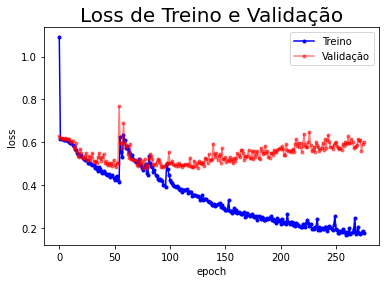

In [ ]:
plt.plot(history.history['loss'], '-b.')
plt.plot(history.history['val_loss'], '-r.', alpha = 0.5)
plt.title('Loss de Treino e Validação',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Treino', 'Validação'], loc='upper right')

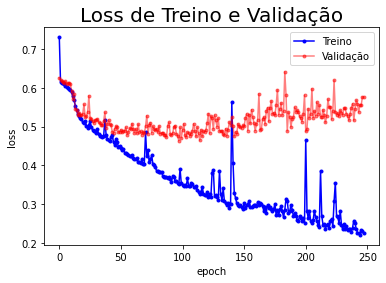

In [ ]:
plt.plot(history2.history['loss'], '-b.')
plt.plot(history2.history['val_loss'], '-r.', alpha = 0.5)
plt.title('Loss de Treino e Validação',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Treino', 'Validação'], loc='upper right')

In [ ]:
model1.evaluate(x_test, y_test, batch_size=1)

2118/2118 [==============================] - 19s 9ms/step - loss: 0.4800 - acc: 0.8447


[0.4799891710281372, 0.8446647524833679]

In [ ]:
model2.evaluate(x_test, y_test, batch_size=1)

2118/2118 [==============================] - 20s 9ms/step - loss: 0.4632 - acc: 0.8466


[0.4631538689136505, 0.8465533256530762]

#Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# y_test = np.concatenate([y for x, y in test_batches], axis=0)
# x_test = np.concatenate([x for x, y in test_batches], axis=0)
rounded_labels=np.argmax(y_test, axis=1)

Confusion Matrix
[[   0    0   19    1    3   14]
 [   0    0   19    0    0   23]
 [  13    0 1758    4   28    6]
 [   0    1   64   11    1   27]
 [   0    0   33    3    9   24]
 [   0    0   33   12    1   11]]
Classification Report
                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00        37
 Bronchiolitis       0.00      0.00      0.00        42
          COPD       0.91      0.97      0.94      1809
       Healthy       0.35      0.11      0.16       104
     Pneumonia       0.21      0.13      0.16        69
          URTI       0.10      0.19      0.14        57

      accuracy                           0.84      2118
     macro avg       0.26      0.23      0.23      2118
  weighted avg       0.81      0.84      0.82      2118

Confusion matrix, without normalization
[[   0    0   19    1    3   14]
 [   0    0   19    0    0   23]
 [  13    0 1758    4   28    6]
 [   0    1   64   11    1   27]
 [   0    0   33    3    9 

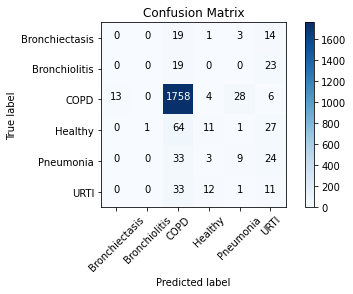

In [ ]:
Y_pred = model1.predict(x_test)         #ALTERAR AQUI >> nome_do_modelo.predict(amostras de teste)
y_pred = np.argmax(Y_pred, axis=1)                    
print('Confusion Matrix')
print(confusion_matrix(rounded_labels, y_pred))               #ALTERAR AQUI >> confusion_matrix(rotulos de teste, y_pred)
print('Classification Report')
target_names = classes
print(classification_report(rounded_labels, y_pred, target_names=target_names))       #ALTERAR AQUI 
cm = confusion_matrix(y_true=rounded_labels, y_pred=y_pred)                           #ALTERAR AQUI 
plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')

Confusion Matrix
[[   0    0   26    0    0   11]
 [   0    2   21    1    0   18]
 [   4    1 1762    7   22   13]
 [   0    1   72   13    0   18]
 [   0    0   46   13    6    4]
 [   0    1   37    9    0   10]]
Classification Report
                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00        37
 Bronchiolitis       0.40      0.05      0.09        42
          COPD       0.90      0.97      0.93      1809
       Healthy       0.30      0.12      0.18       104
     Pneumonia       0.21      0.09      0.12        69
          URTI       0.14      0.18      0.15        57

      accuracy                           0.85      2118
     macro avg       0.32      0.23      0.25      2118
  weighted avg       0.80      0.85      0.82      2118

Confusion matrix, without normalization
[[   0    0   26    0    0   11]
 [   0    2   21    1    0   18]
 [   4    1 1762    7   22   13]
 [   0    1   72   13    0   18]
 [   0    0   46   13    6 

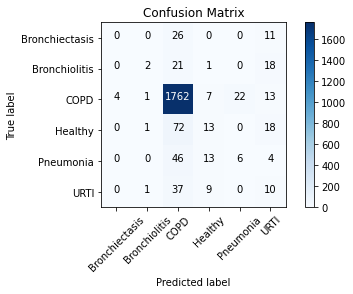

In [ ]:
Y_pred = model2.predict(x_test)         #ALTERAR AQUI >> nome_do_modelo.predict(amostras de teste)
y_pred = np.argmax(Y_pred, axis=1)                    
print('Confusion Matrix')
print(confusion_matrix(rounded_labels, y_pred))               #ALTERAR AQUI >> confusion_matrix(rotulos de teste, y_pred)
print('Classification Report')
target_names = classes
print(classification_report(rounded_labels, y_pred, target_names=target_names))       #ALTERAR AQUI 
cm = confusion_matrix(y_true=rounded_labels, y_pred=y_pred)                           #ALTERAR AQUI 
plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')